In [113]:
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import READ_EDAB_Utilities_py as reupy
from scipy.interpolate import RegularGridInterpolator

In [3]:
#url = 'http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/northwest_atlantic/forecast/tob_forecast_i199303.nc'
#forecast_test = xr.open_dataset(url)

In [111]:
glbt

<xarray.Dataset>
Dimensions:    (latitude: 217, longitude: 241, time: 342)
Coordinates:
  * latitude   (latitude) float32 30.0 30.08 30.17 30.25 ... 47.83 47.92 48.0
  * longitude  (longitude) float32 -80.0 -79.92 -79.83 ... -60.17 -60.08 -60.0
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2021-06-01
Data variables:
    bottomT    (time, latitude, longitude) float32 ...

In [108]:
glbt = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/bt_glorys_M.nc')

In [14]:
mom6bt = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/ocean_monthly.199301-201912.tob.nc')

In [10]:
static = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/ocean_static_deptho.nc')

In [115]:
gl_regrid = np.empty([342, 774, 844])
#gl_lons = np.concatenate((np.array(bt_glorys.longitude[:2161]+360), np.array(bt_glorys.longitude[2161:])))
LAT, LON = np.meshgrid(mom6bt.lat.values, mom6bt.lon.values-360)
for i in range(342):
    interp_to_mom6 = RegularGridInterpolator((glbt.latitude.values, glbt.longitude.values), glbt.bottomT[i,:,:].values, bounds_error = False, fill_value = np.nan)
    gl_regrid[i,:,:] = interp_to_mom6((LAT, LON))


In [121]:
bt_gl = xr.Dataset(data_vars = {'tob': (['time','lon','lat'], gl_regrid)},
                          coords = {'time': glbt.time,
                                    'lat': mom6bt.lat,
                                    'lon': mom6bt.lon})

In [122]:
#subset to the SNE+MAB
# Load in the shapefile
epu = gpd.read_file('EPU_shape/EPU_NOESTUARIES.shp')
mab = epu[epu.EPU == 'MAB']
mab_m6 = reupy.crop_nd(mom6bt, 'lon', 'lat', mab)
mab_gl = reupy.crop_nd(bt_gl, 'lon', 'lat', mab)

In [123]:
#remove everything,200m
mab_m6_200 = mab_m6.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
mab_gl_200 = mab_gl.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))

In [124]:
#remove everything except june-sept
def is_jjas(month):
    return (month >= 6) & (month <= 9)

mab_m6_200_jjas = mab_m6_200.sel(time=is_jjas(mab_m6_200['time.month']))
mab_gl_200_jjas = mab_gl_200.sel(time=is_jjas(mab_gl_200['time.month']))

In [125]:
#calculate june-sept climatetological temp at each gridcell
clim_m6 = mab_m6_200_jjas.mean('time')
clim_gl = mab_gl_200_jjas.mean('time')

In [126]:
# remove everything that is greater than 10C

clim_10_m6 = clim_m6.where(clim_m6.tob <=10)
clim_10_gl = clim_gl.where(clim_gl.tob <=10)

mab_m6_200_jjas_10 = mab_m6_200_jjas.where(clim_m6.tob <=10)
mab_gl_200_jjas_10 = mab_gl_200_jjas.where(clim_gl.tob <= 10)

$$ Model\, CPI_y =\frac{ \sum_{i=1}^{n} {(T_{i,y} - \bar{T}_{i,\, 1972-2019})}} {n} $$



In [78]:
# Here we just use the time domain of the model 1993-2019 for Tbar

top_of_fraction_test = mab_m6_200_jjas_10.groupby('time.year').mean('time') - clim_10

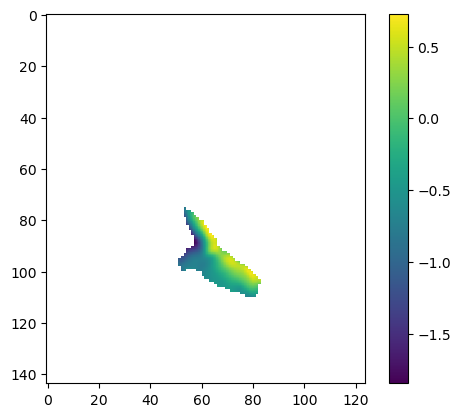

In [79]:
plt.imshow(top_of_fraction_test.tob[10,:,:])
plt.colorbar()

522

In [129]:
M_CPIy_m6 = (mab_m6_200_jjas_10.groupby('time.year').mean('time') - clim_10_m6).sum(['lat','lon'])/len(np.where(np.isnan(clim_10_m6.tob) == False)[0])

M_CPIy_gl = (mab_gl_200_jjas_10.groupby('time.year').mean('time') - clim_10_gl).sum(['lat','lon'])/len(np.where(np.isnan(clim_10_gl.tob) == False)[0])


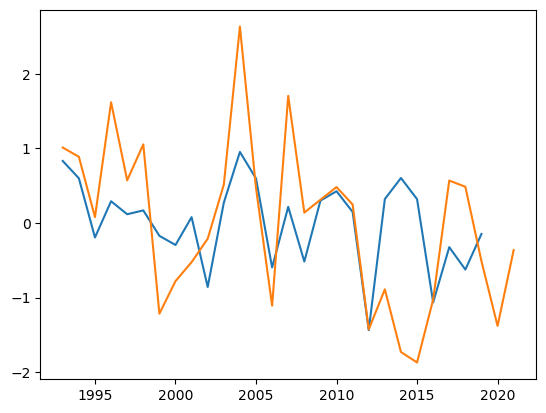

In [130]:
plt.plot(M_CPIy_m6.year, M_CPIy_m6.tob*-1)
plt.plot(M_CPIy_gl.year, M_CPIy_gl.tob*-1)

In [104]:
M_CPIy

<xarray.Dataset>
Dimensions:  (year: 27)
Coordinates:
  * year     (year) int64 1993 1994 1995 1996 1997 ... 2015 2016 2017 2018 2019
Data variables:
    tob      (year) float32 -0.8306 -0.5985 0.1943 ... 0.3245 0.6248 0.1472